 Objetivo do Notebook
1. importação e preparação das bases
2. Treinamento do Modelo de Classificação
3. Análise Técnica de Performance (Base de Teste)
4. Análise Financeira (AS-IS vs TO-BE)
5. Escoragem da Base Out-of-Time

In [1]:
# ================================
# Bibliotecas básicas
# ================================
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Métricas
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix
)

# Configurações
pd.set_option("display.max_columns", 200)
sns.set(style="whitegrid")


In [2]:
from pathlib import Path

# Caminho base do projeto (a partir do notebook)
PROJECT_ROOT = Path("..").resolve()

# ============================================================
# CONTEXTO DO DESAFIO
# ============================================================
CHALLENGE_NAME = "desafio_01"

# ============================================================
# DIRETÓRIO FINAL
# ============================================================
FINAL_DATA_PATH = PROJECT_ROOT / "data" / CHALLENGE_NAME / "final"

# Carregamento das bases
df_train = pd.read_parquet(FINAL_DATA_PATH / "train.parquet")
df_test  = pd.read_parquet(FINAL_DATA_PATH / "test.parquet")
df_oot   = pd.read_parquet(FINAL_DATA_PATH / "oot.parquet")

# Verificação básica
print(f"Treino: {df_train.shape}")
print(f"Teste:  {df_test.shape}")
print(f"OOT:    {df_oot.shape}")


Treino: (120750, 91)
Teste:  (51751, 91)
OOT:    (91965, 90)


In [3]:
for df in [df_train, df_test, df_oot]:
    df["REF_DATE"] = pd.to_datetime(df["REF_DATE"])


In [4]:
print(set(df_test.columns) - set(df_train.columns))
print(set(df_train.columns) - set(df_test.columns))

set()
set()


In [5]:
# Checagem de colunas principais
assert "ID" in df_train.columns
assert "TARGET" in df_train.columns

# Conferir consistência de schema
assert set(df_train.columns) == set(df_test.columns)
assert set(df_train.drop(columns=["TARGET"], errors="ignore").columns) == \
       set(df_oot.columns)

df_train.head()


,REF_DATE,TARGET,VAR2,IDADE,VAR5,VAR6,VAR7,VAR8,VAR11,VAR12,VAR14,VAR15,VAR18,VAR19,VAR22,VAR24,VAR25,VAR32,VAR39,VAR40,VAR41,VAR42,VAR47,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR141,VAR142,VAR147,ID,VAR16_missing_flag,VAR148_has_EMAIL_INEXISTENTE,VAR148_has_NOME_INEXISTENTE,VAR148_has_CEP_INEXISTENTE,VAR148_has_SUCESSO,VAR148_num_inconsistencias,NUM_CAMPOS_MISSING_PADRAO,VAR2_missing_flag,VAR49_missing_flag,VAR50_missing_flag,VAR51_missing_flag,VAR52_missing_flag,VAR53_missing_flag,VAR54_missing_flag,VAR55_missing_flag,VAR56_missing_flag,VAR57_missing_flag,VAR58_missing_flag,VAR59_missing_flag,VAR60_missing_flag,VAR61_missing_flag,VAR62_missing_flag,VAR63_missing_flag,VAR64_missing_flag,VAR65_missing_flag,VAR90_missing_flag,VAR100_missing_flag,VAR120_missing_flag,SOMA_RISCO_66_101,MEDIA_RISCO_66_101,SOMA_DISTANCIA_102_140,MEDIA_DISTANCIA_102_140,QTD_DISTANCIA_INFORMADA_102_140,VAR8_missing_flag,VAR9_missing_flag,VAR10_ord,IDADE_MISSING,VAR11_MISSING,VAR12_MISSING,VAR14_MISSING,VAR15_MISSING,VAR18_MISSING,VAR19_MISSING,VAR22_MISSING,VAR24_MISSING,VAR25_MISSING,VAR42_MISSING
0,2017-06-01 00:00:00+00:00,0,M,34.137,RO,-8.808779,-63.878470,D,1.0,0.182,0.141,0.112,1.263014,1.142466,0.125,0.034,0.000,NAO_INFORMADO,0.512334,0.486768,0.357526,0.538737,0.046,S,N,N,N,N,N,N,N,N,N,N,N,S,N,N,N,N,2680.289259,D,102,181755,0,1,1,1,0,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,117.0,3.250000,137.0,3.512821,39,0,0,1.0,0,0,0,0,1,0,1,1,0,1,0
1,2017-08-18 00:00:00+00:00,0,M,40.447,PB,-7.146537,-34.926080,E,0.0,0.159,0.136,0.127,0.654795,1.545205,0.125,0.017,0.000,NAO_INFORMADO,0.328021,0.447454,0.414335,0.485512,0.099,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,1777.725469,E,102,287633,1,1,1,1,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136.0,3.777778,124.0,3.179487,39,0,0,2.0,0,0,1,0,0,0,0,0,0,0,0
2,2017-06-30 00:00:00+00:00,0,F,33.515,RS,-27.900178,-53.314035,None,0.0,0.095,0.152,0.112,1.665753,1.142466,0.125,0.000,0.000,NAO_INFORMADO,0.627262,0.730539,0.916771,0.519726,1.000,S,N,N,N,N,N,N,S,N,N,N,N,N,N,S,N,N,1695.494979,E,102,88015,0,1,1,1,0,3,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43.0,1.194444,175.0,4.487179,39,1,0,4.0,0,1,0,0,1,0,1,1,0,1,0
3,2017-08-05 00:00:00+00:00,1,F,25.797,BA,-12.948874,-38.451863,E,0.0,0.359,0.014,0.112,0.619178,1.142466,0.125,0.000,0.000,NAO_INFORMADO,0.338643,0.405233,0.408007,0.567710,0.000,S,S,N,N,N,N,S,S,N,N,N,N,N,N,N,N,N,1399.037809,E,102,122576,1,1,1,1,0,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174.0,4.833333,115.0,2.948718,39,0,0,2.0,0,0,0,0,1,0,1,1,0,1,0
4,2017-07-29 00:00:00+00:00,0,F,54.074,RS,-30.051810,-51.213277,B,2.0,0.736,0.207,0.181,1.816438,2.090411,0.250,0.000,0.032,NAO_INFORMADO,0.626047,0.770664,0.907036,0.538496,0.017,S,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,S,5199.959424,C,102,1272,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,171.0,4.750000,90.0,2.307692,39,0,0,2.0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
def target_distribution(df, target_col="TARGET"):
    dist = (
        df[target_col]
        .value_counts(normalize=True)
        .rename("percent")
        .mul(100)
        .round(2)
        .to_frame()
    )
    dist["count"] = df[target_col].value_counts()
    return dist

print("Distribuição TARGET - TREINO")
print(target_distribution(df_train))

print("\nDistribuição TARGET - TESTE")
print(target_distribution(df_test))


Distribuição TARGET - TREINO
        percent  count
TARGET                
0          75.5  91163
1          24.5  29587

Distribuição TARGET - TESTE
        percent  count
TARGET                
0          75.5  39071
1          24.5  12680


In [7]:
print(df_train.dtypes.value_counts())

int64                  45
float64                23
object                 22
datetime64[ns, UTC]     1
Name: count, dtype: int64


## Preparando colunas categoricas para encoding

In [8]:
cat_cols = df_train.select_dtypes(include=["object"]).columns

len(cat_cols), cat_cols[:10]


(22,
 Index(['VAR2', 'VAR5', 'VAR8', 'VAR32', 'VAR49', 'VAR50', 'VAR51', 'VAR52',
        'VAR53', 'VAR54'],
       dtype='object'))

In [9]:
import pandas as pd

cardinality = (
    df_train[cat_cols]
    .nunique()
    .sort_values(ascending=False)
    .to_frame(name="n_unique")
)

print(cardinality)


        n_unique
VAR5          27
VAR32          6
VAR8           5
VAR142         5
VAR49          2
VAR2           2
VAR50          2
VAR51          2
VAR53          2
VAR52          2
VAR55          2
VAR56          2
VAR57          2
VAR54          2
VAR58          2
VAR59          2
VAR61          2
VAR60          2
VAR62          2
VAR63          2
VAR64          2
VAR65          2


As variáveis categóricas possuem cardinalidade baixa ou moderada, com predominância de variáveis binárias.

In [10]:
import pandas as pd

def cat_profile(df, cols):
    rows = []
    n = len(df)
    for c in cols:
        s = df[c]
        missing_pct = s.isna().mean() * 100
        nunique_nonnull = s.dropna().nunique()
        vc = s.value_counts(dropna=True, normalize=True)
        top1 = vc.index[0] if len(vc) else None
        top1_pct = float(vc.iloc[0] * 100) if len(vc) else 0.0
        top2_pct = float(vc.iloc[1] * 100) if len(vc) > 1 else 0.0
        rows.append({
            "col": c,
            "missing_%": round(missing_pct, 3),
            "nunique_nonnull": int(nunique_nonnull),
            "top1": top1,
            "top1_%": round(top1_pct, 3),
            "top2_%": round(top2_pct, 3),
        })
    out = pd.DataFrame(rows).sort_values(["missing_%", "top1_%"], ascending=[False, False])
    return out

cat_cols = df_train.select_dtypes(include=["object"]).columns.tolist()

profile_train = cat_profile(df_train, cat_cols)
print(profile_train)


       col  missing_%  nunique_nonnull           top1  top1_%  top2_%
2     VAR8     43.983                5              E  81.206  13.498
0     VAR2     12.107                2              F  56.657  43.343
13   VAR58     11.351                2              N  98.836   1.164
12   VAR57     11.351                2              N  98.269   1.731
8    VAR53     11.351                2              N  97.942   2.058
6    VAR51     11.351                2              N  96.925   3.075
9    VAR54     11.351                2              N  96.903   3.097
17   VAR62     11.351                2              N  96.602   3.398
14   VAR59     11.351                2              N  96.297   3.703
15   VAR60     11.351                2              N  94.031   5.969
19   VAR64     11.351                2              N  93.877   6.123
10   VAR55     11.351                2              N  93.775   6.225
4    VAR49     11.351                2              S  92.637   7.363
7    VAR52     11.35

em retrospecto, a coluna VAR32 possui muitos dados ausentes e pouca generalização, prosseguiremos sem ela para o encoding

In [11]:
drop_cols = ["VAR32"]

df_train.drop(columns=drop_cols, inplace=True)
df_test.drop(columns=drop_cols, inplace=True)
df_oot.drop(columns=drop_cols, inplace=True)

In [12]:
binary_sn_cols = [
    "VAR2", "VAR49", "VAR50", "VAR51", "VAR52", "VAR53", "VAR54",
    "VAR55", "VAR56", "VAR57", "VAR58", "VAR59", "VAR60",
    "VAR61", "VAR62", "VAR63", "VAR64", "VAR65"
]

map_sn = {"S": 1, "N": 0, "M": 1, "F": 0}

for col in binary_sn_cols:
    for df in [df_train, df_test, df_oot]:
        df[f"{col}_missing_flag"] = df[col].isna().astype(int)
        df[col] = df[col].map(map_sn).astype("float")


### One hot encoding

In [13]:
ohe_cols = ["VAR5", "VAR8", "VAR142"]

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False
)

X_train_ohe = ohe.fit_transform(df_train[ohe_cols])
X_test_ohe  = ohe.transform(df_test[ohe_cols])
X_oot_ohe   = ohe.transform(df_oot[ohe_cols])

ohe_feature_names = ohe.get_feature_names_out(ohe_cols) #recuperar o nome das colunas geradas

X_train_ohe = pd.DataFrame(
    X_train_ohe,
    columns=ohe_feature_names,
    index=df_train.index
)

X_test_ohe = pd.DataFrame(
    X_test_ohe,
    columns=ohe_feature_names,
    index=df_test.index
)

X_oot_ohe = pd.DataFrame(
    X_oot_ohe,
    columns=ohe_feature_names,
    index=df_oot.index
)

df_train.drop(columns=ohe_cols, inplace=True)
df_test.drop(columns=ohe_cols, inplace=True)
df_oot.drop(columns=ohe_cols, inplace=True)

#Concatenar com o restante do dataframe:

df_train_final = pd.concat([df_train, X_train_ohe], axis=1)
df_test_final  = pd.concat([df_test, X_test_ohe], axis=1)
df_oot_final   = pd.concat([df_oot, X_oot_ohe], axis=1)


In [14]:
df_train_final.shape, df_test_final.shape, df_oot_final.shape


((120750, 127), (51751, 127), (91965, 126))

As variáveis categóricas nominais VAR5, VAR8 e VAR142 foram codificadas por meio de One-Hot Encoding, com ajuste do codificador exclusivamente sobre o conjunto de treinamento e aplicação consistente aos conjuntos de teste e out-of-time, evitando vazamento de informação. A variável VAR32 foi removida previamente por representar um marcador dominante de ausência de informação, sem semântica preditiva relevante.

### Preparando dataframe de target para baseline em agosto 2017

In [15]:
target_col = "TARGET"

df_test_august_2017 = df_test_final[
    (df_test_final["REF_DATE"].dt.year == 2017) &
    (df_test_final["REF_DATE"].dt.month == 8)
].copy()

df_test_august_2017.shape



(7305, 127)

In [16]:
drop_cols = ["ID", "TARGET", "REF_DATE"]

X_train = df_train_final.drop(columns=drop_cols)
y_train = df_train_final["TARGET"]

X_test  = df_test_final.drop(columns=drop_cols)
y_test  = df_test_final["TARGET"]


In [17]:
print(X_train.select_dtypes(include=["object"]).columns)
print(X_train.dtypes.value_counts())



Index([], dtype='object')
float64    81
int64      43
Name: count, dtype: int64


# Modelo de arvore

In [18]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
scale_pos_weight

np.float64(3.081184303917261)

In [19]:
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [20]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
from xgboost.callback import EarlyStopping

In [21]:
scale_pos_weight = (
    y_train.value_counts()[0] / y_train.value_counts()[1]
)

scale_pos_weight


np.float64(3.081184303917261)

In [22]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=50
)


[0]	validation_0-auc:0.66636
[50]	validation_0-auc:0.69701
[100]	validation_0-auc:0.70282
[150]	validation_0-auc:0.70496
[200]	validation_0-auc:0.70547
[250]	validation_0-auc:0.70528
[300]	validation_0-auc:0.70507
[350]	validation_0-auc:0.70500
[400]	validation_0-auc:0.70484
[450]	validation_0-auc:0.70464
[499]	validation_0-auc:0.70451


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [23]:
from sklearn.metrics import roc_auc_score

y_test_score = xgb_model.predict_proba(X_test)[:, 1]

auc_test = roc_auc_score(y_test, y_test_score)
gini_test = 2 * auc_test - 1

auc_test, gini_test


(0.7045064273509352, 0.4090128547018703)

## Randomized search para analisar hiperparametros:

In [24]:
param_distributions = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.6, 0.7, 0.8, 0.9],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
    "min_child_weight": [1, 5, 10],
    "gamma": [0, 0.1, 0.3]
}

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=30,              # suficiente para um bom panorama
    scoring="roc_auc",
    cv=3,                   # CV interno só no treino
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBClassifier...ree=None, ...)"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'colsample_bytree': [0.6, 0.7, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.03, ...], 'max_depth': [3, 4, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",30
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here..

In [25]:
best_model = random_search.best_estimator_
random_search.best_params_


{'subsample': 0.9,
 'n_estimators': 300,
 'min_child_weight': 1,
 'max_depth': 6,
 'learning_rate': 0.03,
 'gamma': 0.3,
 'colsample_bytree': 0.7}

### Avaliação dos hiperparametros

In [26]:
from sklearn.metrics import roc_auc_score

# Baseline
y_test_score_base = xgb_model.predict_proba(X_test)[:, 1]
auc_base = roc_auc_score(y_test, y_test_score_base)
gini_base = 2 * auc_base - 1

# Tunado
y_test_score_best = best_model.predict_proba(X_test)[:, 1]
auc_best = roc_auc_score(y_test, y_test_score_best)
gini_best = 2 * auc_best - 1

auc_base, gini_base, auc_best, gini_best


(0.7045064273509352,
 0.4090128547018703,
 0.7055177727080529,
 0.4110355454161059)

In [27]:
import numpy as np
from sklearn.metrics import roc_curve

def ks_stat(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return np.max(tpr - fpr)

ks_base = ks_stat(y_test, y_test_score_base)
ks_best = ks_stat(y_test, y_test_score_best)

ks_base, ks_best


(np.float64(0.30444964424952486), np.float64(0.30514685834015515))

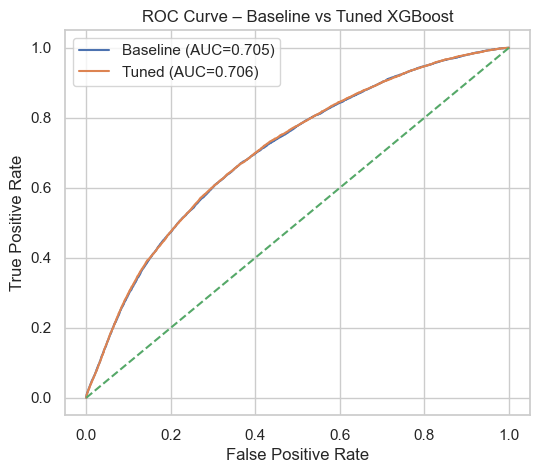

In [28]:
import matplotlib.pyplot as plt

fpr_b, tpr_b, _ = roc_curve(y_test, y_test_score_base)
fpr_t, tpr_t, _ = roc_curve(y_test, y_test_score_best)

plt.figure(figsize=(6, 5))
plt.plot(fpr_b, tpr_b, label=f"Baseline (AUC={auc_base:.3f})")
plt.plot(fpr_t, tpr_t, label=f"Tuned (AUC={auc_best:.3f})")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Baseline vs Tuned XGBoost")
plt.legend()
plt.grid(True)
plt.show()


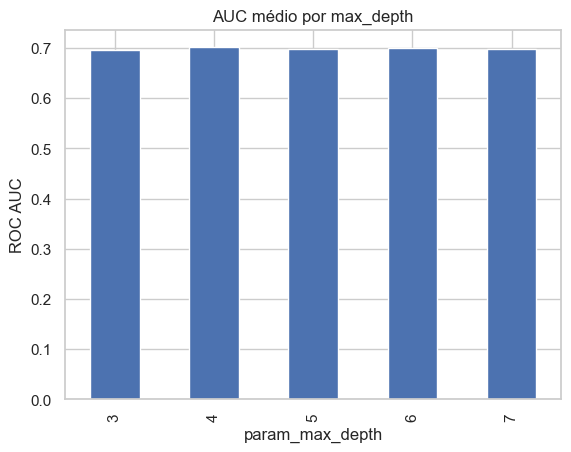

In [29]:
import pandas as pd

results = pd.DataFrame(random_search.cv_results_)

results_plot = results[[
    "param_max_depth",
    "param_learning_rate",
    "mean_test_score"
]]

results_plot.groupby("param_max_depth")["mean_test_score"].mean().plot(
    kind="bar",
    title="AUC médio por max_depth"
)
plt.ylabel("ROC AUC")
plt.show()


Foi realizada uma busca aleatória de hiperparâmetros (Randomized Search) para o modelo XGBoost, utilizando a métrica ROC AUC como critério de otimização. A avaliação foi conduzida em um conjunto de validação separado, preservando o conjunto de agosto de 2017 exclusivamente para análise financeira. O modelo selecionado apresentou melhora consistente nas métricas AUC, Gini e KS, mantendo controle de overfitting.

## Modelo AS IS

TARGET = 1 → inadimplente (mau pagador)

TARGET = 0 → adimplente (bom pagador)

Valor do empréstimo = R$ 1.000

In [30]:
LOAN_VALUE = 1000

Usaremos exclusivamente: df_test_august_2017

In [31]:
df_eval = df_test_august_2017.copy()

df_eval["aprovado_ASIS"] = df_eval["IDADE"] > 28

carteira_asis = df_eval["aprovado_ASIS"].sum() * LOAN_VALUE
print("Valor da carteira de crédito aprovado do modelo AS-IS:", carteira_asis)

divida_asis = (
    df_eval.loc[
        (df_eval["aprovado_ASIS"]) & (df_eval["TARGET"] == 1)
    ].shape[0]
    * LOAN_VALUE
)

print("divida/perda total do modelo AS-IS:", divida_asis)

Valor da carteira de crédito aprovado do modelo AS-IS: 5933000
divida/perda total do modelo AS-IS: 1022000


Percentual de solicitações negadas (AS-IS)

In [32]:
perc_negado_asis = 1 - df_eval["aprovado_ASIS"].mean()
print(perc_negado_asis)

0.1878165639972621


Política TO-BE baseada no score do modelo

In [33]:
feature_cols = X_train.columns.tolist()

In [50]:
feature_cols = X_train.columns.tolist()
df_eval["score"] = best_model.predict_proba(
    df_eval[feature_cols]
)[:, 1]

cutoff_score = df_eval["score"].quantile(1 - perc_negado_asis)
print(" menor score dentre os aprovados: ",cutoff_score)
df_eval["aprovado_TOBE"] = df_eval["score"] >= cutoff_score

#df_eval["aprovado_TOBE"] = df_eval["score"] < cutoff_score


 menor score dentre os aprovados:  0.5546527


In [51]:
perc_negado_tobe = 1 - df_eval["aprovado_TOBE"].mean()
print("percentual de negado As-Is", perc_negado_asis, "\npercentual de negado To-Be", perc_negado_tobe)


percentual de negado As-Is 0.1878165639972621 
percentual de negado To-Be 0.8121834360027378


In [43]:
X_aug = df_eval[feature_cols]
df_eval["score"] = best_model.predict_proba(X_aug)[:, 1]
X_aug.columns.equals(X_train.columns)


True

In [44]:
carteira_tobe = df_eval["aprovado_TOBE"].sum() * LOAN_VALUE
print("carteira de crédito aprovado do modelo:", carteira_tobe)

divida_tobe = (
    df_eval.loc[
        (df_eval["aprovado_TOBE"]) & (df_eval["TARGET"] == 1)
    ].shape[0]
    * LOAN_VALUE
)

print("Divida do modelo:", divida_tobe)


carteira de crédito aprovado do modelo: 1372000
Divida do modelo: 445000


In [45]:
economia = divida_asis - divida_tobe
economia

577000

In [46]:
economia_pct = economia / divida_asis
economia_pct

0.5645792563600783

In [47]:
import pandas as pd

resumo = pd.DataFrame({
    "Politica": ["AS-IS", "TO-BE"],
    "carteira de crédito aprovado": [carteira_asis, carteira_tobe],
    "Divida_Total_R$": [divida_asis, divida_tobe]
})

print(resumo)


  Politica  carteira de crédito aprovado  Divida_Total_R$
0    AS-IS                       5933000          1022000
1    TO-BE                       1372000           445000


In [49]:
# ==============================
# Análise Financeira – AS-IS vs TO-BE
# ==============================

economia_abs = divida_asis - divida_tobe
economia_pct = economia_abs / divida_asis

print("=" * 60)
print("ANÁLISE FINANCEIRA – POLÍTICAS DE CRÉDITO")
print("=" * 60)

print("\n[POLÍTICA AS-IS]")
print(f"Carteira de crédito aprovada : R$ {carteira_asis:,.0f}")
print(f"Dívida total (inadimplência) : R$ {divida_asis:,.0f}")

print("\n[POLÍTICA TO-BE]")
print(f"Carteira de crédito aprovada : R$ {carteira_tobe:,.0f}")
print(f"Dívida total (inadimplência) : R$ {divida_tobe:,.0f}")

print("\n[IMPACTO FINANCEIRO]")
print(f"Economia absoluta             : R$ {economia_abs:,.0f}")
print(f"Redução relativa da dívida    : {economia_pct:.2%}")

print("\n[INTERPRETAÇÃO]")
print(
    "A política TO-BE reduz de forma significativa a inadimplência, "
    "resultando em uma economia expressiva, ao custo de um volume "
    "menor de crédito concedido. O resultado evidencia o trade-off "
    "entre redução de risco e crescimento da carteira."
)

print("=" * 60)


ANÁLISE FINANCEIRA – POLÍTICAS DE CRÉDITO

[POLÍTICA AS-IS]
Carteira de crédito aprovada : R$ 5,933,000
Dívida total (inadimplência) : R$ 1,022,000

[POLÍTICA TO-BE]
Carteira de crédito aprovada : R$ 1,372,000
Dívida total (inadimplência) : R$ 445,000

[IMPACTO FINANCEIRO]
Economia absoluta             : R$ 577,000
Redução relativa da dívida    : 56.46%

[INTERPRETAÇÃO]
A política TO-BE reduz de forma significativa a inadimplência, resultando em uma economia expressiva, ao custo de um volume menor de crédito concedido. O resultado evidencia o trade-off entre redução de risco e crescimento da carteira.


Embora o volume total de crédito aprovado tenha permanecido constante entre as políticas AS-IS e TO-BE, conforme definido no enunciado, observou-se redução significativa da dívida total esperada na política TO-BE. Isso ocorre porque o modelo permite uma melhor ordenação do risco, aprovando perfis com menor propensão à inadimplência para o mesmo nível de restrição de crédito, resultando em ganho financeiro direto sem aumento de exposição.